# Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, I will just extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [81]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time


import warnings
warnings.filterwarnings("ignore")


from custom_datasets.cifar10_rotation import 
from utils import *

## Generate & Store data

Due to memory issues, can't upload the data on which, the network was trained. But running the below cell, a new repository would be created where your data would be stored.

In [2]:
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        # transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128


trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


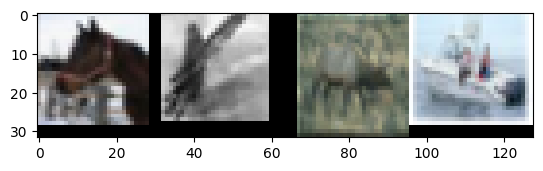

Class labels:  horse plane deer  ship 


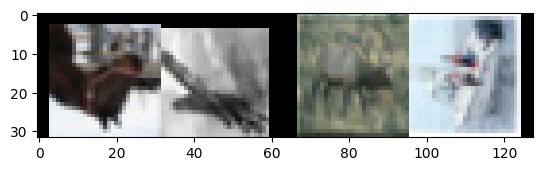

Rotation labels:  180   90    0     90   


In [3]:
classes = ('plane', 'car', 'bird', 'cat',
       'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)

    # Clip the image to be within [0, 1] range
    img = torch.clamp(img, 0, 1)

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [7]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [8]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [9]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4, amsgrad=False)


In [11]:
train(net, criterion, optimizer, num_epochs=50, decay_epochs=27, init_lr=0.001, task='rotation')

# Save the model
save_rotation_model()

[1,   100] loss: 1.259 acc: 44.21 time: 19.38
[1,   200] loss: 1.128 acc: 50.15 time: 4.94
[1,   300] loss: 1.101 acc: 52.34 time: 4.94
TESTING:
Accuracy of the network on the 10000 test images: 57.23 %
Average loss on the 10000 test images: 1.005
[2,   100] loss: 1.040 acc: 55.76 time: 9.36
[2,   200] loss: 1.006 acc: 57.56 time: 4.92
[2,   300] loss: 1.007 acc: 57.23 time: 4.93
TESTING:
Accuracy of the network on the 10000 test images: 59.53 %
Average loss on the 10000 test images: 0.953
[3,   100] loss: 0.971 acc: 59.18 time: 9.38
[3,   200] loss: 0.951 acc: 59.71 time: 4.95
[3,   300] loss: 0.953 acc: 60.11 time: 4.94
TESTING:
Accuracy of the network on the 10000 test images: 60.30 %
Average loss on the 10000 test images: 0.963
[4,   100] loss: 0.929 acc: 61.02 time: 9.38
[4,   200] loss: 0.918 acc: 62.18 time: 5.14
[4,   300] loss: 0.913 acc: 61.56 time: 4.90
TESTING:
Accuracy of the network on the 10000 test images: 62.59 %
Average loss on the 10000 test images: 0.946
[5,   100] 

## Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [55]:
from types import new_class
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# Load the pre-trained ResNet18 model
net = resnet18(num_classes=4) # we do not specify ``weights``, i.e. create untrained model
net.load_state_dict(torch.load("save_model/self_supervised_rotation_model.pth"))

<All keys matched successfully>

In [57]:
# Freeze all layers
for param in net.parameters():
    param.requires_grad = False

# Unfreeze last layer
for param in net.layer4.parameters():
    param.requires_grad = True


# Replace last layer
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)
net = net.to(device)

In [58]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [59]:
# Note that optimizer only needs to update the parameters that are trainable.
criterion = None
optimizer = None

optimizer = optim.Adam(params_to_update, lr=0.001, weight_decay=1e-4, amsgrad=False)
criterion = nn.CrossEntropyLoss()


In [60]:
train(net, criterion, optimizer, num_epochs=25, decay_epochs=15, init_lr=0.001, task='classification')

[1,   100] loss: 1.833 acc: 32.20 time: 7.34
[1,   200] loss: 1.514 acc: 43.48 time: 2.97
[1,   300] loss: 1.467 acc: 45.98 time: 2.95
TESTING:
Accuracy of the network on the 10000 test images: 50.15 %
Average loss on the 10000 test images: 1.375
[2,   100] loss: 1.397 acc: 48.24 time: 7.63
[2,   200] loss: 1.394 acc: 48.73 time: 2.90
[2,   300] loss: 1.384 acc: 49.44 time: 2.91
TESTING:
Accuracy of the network on the 10000 test images: 50.98 %
Average loss on the 10000 test images: 1.380
[3,   100] loss: 1.368 acc: 49.80 time: 7.36
[3,   200] loss: 1.330 acc: 51.85 time: 2.92
[3,   300] loss: 1.343 acc: 50.73 time: 2.92
TESTING:
Accuracy of the network on the 10000 test images: 53.37 %
Average loss on the 10000 test images: 1.291
[4,   100] loss: 1.327 acc: 51.38 time: 7.28
[4,   200] loss: 1.312 acc: 52.57 time: 2.92
[4,   300] loss: 1.309 acc: 52.17 time: 2.91
TESTING:
Accuracy of the network on the 10000 test images: 53.63 %
Average loss on the 10000 test images: 1.284
[5,   100] l

## Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [77]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18


net = resnet18(num_classes=4) # we do not specify ``weights``, i.e. create untrained model
net.load_state_dict(torch.load("save_model/self_supervised_rotation_model.pth"))

<All keys matched successfully>

In [78]:
# Replace last layer
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)
net = net.to(device)

In [79]:
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = None
optimizer = None

optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4, amsgrad=False)
criterion = nn.CrossEntropyLoss()


In [80]:
train(net, criterion, optimizer, num_epochs=12, decay_epochs=8, init_lr=0.001, task='classification')

[1,   100] loss: 1.460 acc: 46.96 time: 9.39
[1,   200] loss: 1.060 acc: 62.13 time: 4.91
[1,   300] loss: 0.938 acc: 67.58 time: 5.16
TESTING:
Accuracy of the network on the 10000 test images: 70.45 %
Average loss on the 10000 test images: 0.855
[2,   100] loss: 0.833 acc: 70.73 time: 9.97
[2,   200] loss: 0.823 acc: 71.34 time: 4.92
[2,   300] loss: 0.795 acc: 72.86 time: 5.04
TESTING:
Accuracy of the network on the 10000 test images: 73.39 %
Average loss on the 10000 test images: 0.788
[3,   100] loss: 0.749 acc: 74.97 time: 9.71
[3,   200] loss: 0.721 acc: 74.83 time: 5.01
[3,   300] loss: 0.716 acc: 75.04 time: 5.10
TESTING:
Accuracy of the network on the 10000 test images: 75.59 %
Average loss on the 10000 test images: 0.710
[4,   100] loss: 0.668 acc: 76.88 time: 9.77
[4,   200] loss: 0.678 acc: 76.30 time: 5.15
[4,   300] loss: 0.656 acc: 77.45 time: 5.07
TESTING:
Accuracy of the network on the 10000 test images: 75.93 %
Average loss on the 10000 test images: 0.729
[5,   100] l